In [1]:
import torch
from glob import glob
from pathlib import Path
import numpy as np
from tqdm import tqdm
import cv2
from cnn4 import CNN4
from datamodule import Datamodule
from params import LocationConfig, TrainingConfig, CreateDataConfig
from torch.nn import functional as F
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
cnn4 = CNN4(
        lr=TrainingConfig.lr,
        batch_norm=TrainingConfig.batch_norm,
        negative_slope=TrainingConfig.negative_slope,
        dropout = TrainingConfig.dropout
        )
summary(cnn4.cuda(), (128, 128, 1) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
              ReLU-2         [-1, 16, 128, 128]               0
           Dropout-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           4,640
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
        MaxPool2d-14            [-1, 51

In [4]:
checkpoints_dir = Path(LocationConfig.checkpoints_dir)
list_of_checkpoints = list(checkpoints_dir.glob("*.ckpt"))
latest_checkpoint_path = max(list_of_checkpoints, key=lambda p: p.stat().st_ctime)

cnn4 = CNN4(lr=0.0001, batch_norm=False, dropout=0.2, batch_size=2, negative_slope=0.0)\
    .load_from_checkpoint(checkpoint_path=latest_checkpoint_path)
cnn4.eval();
cnn4.state_dict()['conv.conv_0.weight'][0]

tensor([[[ 0.2577,  0.2794, -0.0790],
         [ 0.3109, -0.0686,  0.0687],
         [-0.1655,  0.1929,  0.2899]]])

In [7]:
train_data_path = Path(LocationConfig.new_data + 'train')
test_data_path = Path(LocationConfig.new_data + 'test')
dm = Datamodule(
        batch_size=TrainingConfig.batch_size,
        train_dir=train_data_path,
        val_dir=test_data_path,
        )
dm.setup(val_only=True)
# dm.setup()

file: my_data/test/test.pickle


 11%|█         | 1/9 [00:00<00:00,  9.68it/s]


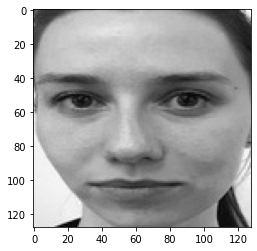

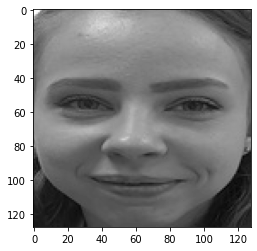

In [8]:
from matplotlib import pyplot as plt
i=0
for batch in tqdm(dm.val_dataloader()):
#     print(batch['normalized'].shape)
    plt.figure()
    plt.imshow(batch['normalized'][0,:,:,0], cmap='gray')
#     print(batch['normalized'][0,:3,:3])
    if i == 1:
        break
    i+=1

In [11]:
acc_class_global_1 = np.zeros(5)
acc_class_global_12 = np.zeros(5)
i=0
for batch in tqdm(dm.val_dataloader()):
    X, Y = batch['normalized'], batch['label']
    Y_pred = cnn4.predict_step(X, None)
    Y_pred_12 = np.where(Y_pred > 1/2, 1, 0)
    Y_pred_1 = np.ones_like(Y)
    acc_class_12 = np.sum(Y_pred_12 == np.array(Y), axis=0) / len(Y)
    acc_class_1 = np.sum(Y_pred_1 == np.array(Y), axis=0) / len(Y)
    acc_class_global_12 += acc_class_12
    acc_class_global_1 += acc_class_1
    i+=1
acc_class_global_12 /= i
print('1/2')
print(acc_class_global_12)
print(acc_class_global_12.mean())

acc_class_global_1 /= i
print('1')
print(acc_class_global_1)
print(acc_class_global_1.mean())

100%|██████████| 9/9 [00:06<00:00,  1.39it/s]

1/2
[0.44444444 0.72222222 0.55555556 0.66666667 0.61111111]
0.6
1
[0.66666667 0.77777778 0.94444444 0.22222222 0.66666667]
0.6555555555555556
